# Baseline Modeling notebook

In [1]:
import logging
import os
import gcsfs

from sklearn.decomposition import PCA

from ml_bay12.GCS import GCSLoader
from ml_bay12 import data_prepare

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import re
from sklearn.linear_model import LogisticRegression

import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

### Load data, concatenate text of each user in each thread and get rid of users not taking part in the game

In [2]:
gcs=GCSLoader(project='open-mafia-ml-bay12',path='om-ml-bay12-storage/dataset/ds_mafia')
post=gcs.get_post()
role=gcs.get_role()
post_test=gcs.get_post(which='test')
role_test=gcs.get_role(which='test')

In [3]:
post["text"]=post["text"].apply(data_prepare.clean)
post_test["text"]=post_test["text"].apply(data_prepare.clean)

In [4]:
users_df=data_prepare.concat_users_text(post)
users_test_df=data_prepare.concat_users_text(post_test)

In [5]:
main_df = data_prepare.get_users_in_game(role, users_df)
main_test_df = data_prepare.get_users_in_game(role_test, users_test_df)

In [6]:
train_data=main_df["text"]
y=main_df["role_id"]
y_test=gcs.get_role_answers()["role_id"]
test_data=main_test_df["text"]

In [7]:
post.head()

,thread_num,user,text,quotes
0,39457,Mephansteras,there was some talk about a beginners mafia ga...,[]
1,39457,Pandarsenic,cough i d join,[]
2,39457,Org,im in,[]
3,39457,Mephansteras,sigh ok how about people who haven t been in a...,[]
4,39457,Jim Groovester,i may join just to see what the hell is so gre...,[]


In [8]:
users_df.head()

,thread_num,user,text
0,39457,Mephansteras,there was some talk about a beginners mafia ga...
1,39457,Pandarsenic,cough i d joini think that an intro to how to ...
2,39457,Org,im inwait i am not in why i am not that experi...
3,39457,Jim Groovester,i may join just to see what the hell is so gre...
4,39457,Leafsnail,i ve been studying the rules of a few more pop...


In [10]:
main_df.head()

,thread_num,user,text,final_player,role,role_id,uid
0,39457,Org,im inwait i am not in why i am not that experi...,Org,town,0.0,39457_Org
1,39457,Jim Groovester,i may join just to see what the hell is so gre...,Jim Groovester,town,0.0,39457_Jim_Groovester
2,39457,ToonyMan,arr i ll join if possiblequoted section agreey...,ToonyMan,town,0.0,39457_ToonyMan
3,39457,Eduren,ok im in ive played this game in rl but not on...,Eduren,town,0.0,39457_Eduren
4,39457,BloodBeard,bloodbeard is burdened with many df community ...,BloodBeard,town,0.0,39457_BloodBeard


### Vectorize text and scale features for PCA

In [79]:
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_train = vectorizer.fit_transform(train_data).toarray()
X_test=vectorizer.transform(test_data).toarray()

In [80]:
X_train.shape

(478, 7946)

In [81]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

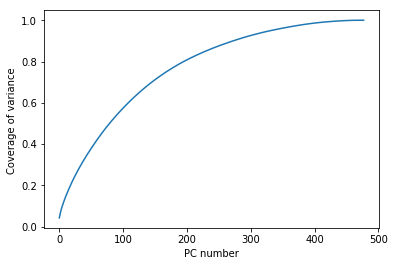

In [83]:
pca = PCA().fit(X_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC number')
plt.ylabel('Coverage of variance ')
plt.show()

In [54]:
pca = PCA(n_components=250)
pC = pca.fit_transform(X_train)
pCTest=pca.transform(X_test)

*The ideal number of PCs might be more precise around 300, but as we've got few samples, let's not make too many components to encourage overfitting*

### A little bit of hyperparameters adjustment

In [39]:
params = {'iterations':[30, 35, 40, 45, 50], 'depth':[2, 3, 4, 5, 6],
              'loss_function': ['Logloss'],
              'learning_rate':[.05, .1, .5]
    }

clf = CatBoostClassifier()
grid=GridSearchCV(clf,param_grid = params , scoring = 'roc_auc', verbose = 5, n_jobs = -1, cv=4)
best_model=grid.fit(pC,y)

Fitting 4 folds for each of 75 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 31.4min finished


0:	learn: 0.6504606	total: 1.12s	remaining: 32.5s
1:	learn: 0.6201200	total: 1.7s	remaining: 23.8s
2:	learn: 0.5926475	total: 2.2s	remaining: 19.8s
3:	learn: 0.5684457	total: 2.78s	remaining: 18.1s
4:	learn: 0.5456283	total: 3.32s	remaining: 16.6s
5:	learn: 0.5307018	total: 3.77s	remaining: 15.1s
6:	learn: 0.5200216	total: 4.2s	remaining: 13.8s
7:	learn: 0.5067875	total: 4.63s	remaining: 12.7s
8:	learn: 0.4971876	total: 5.02s	remaining: 11.7s
9:	learn: 0.4874838	total: 5.41s	remaining: 10.8s
10:	learn: 0.4787189	total: 5.78s	remaining: 9.97s
11:	learn: 0.4711753	total: 6.15s	remaining: 9.22s
12:	learn: 0.4646118	total: 6.46s	remaining: 8.45s
13:	learn: 0.4527072	total: 6.86s	remaining: 7.83s
14:	learn: 0.4460323	total: 7.24s	remaining: 7.24s
15:	learn: 0.4403562	total: 7.57s	remaining: 6.62s
16:	learn: 0.4328928	total: 7.85s	remaining: 6s
17:	learn: 0.4284559	total: 8.13s	remaining: 5.42s
18:	learn: 0.4204557	total: 8.4s	remaining: 4.86s
19:	learn: 0.4156897	total: 8.65s	remaining: 4.3

In [40]:
param=best_model.best_params_
param

{'depth': 5,
 'iterations': 30,
 'learning_rate': 0.1,
 'loss_function': 'Logloss'}

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(pC, y, test_size=0.2, random_state=24)

In [75]:
from catboost import CatBoostClassifier, Pool
eval_dataset = Pool(X_val, y_val)

In [76]:
model = CatBoostClassifier(iterations=30,
                           learning_rate=.1,
                           loss_function='Logloss',
                           verbose=True,
                          use_best_model=True,
                           depth=5,
                          eval_metric='AUC')
model.fit(X_train, y_train, eval_set=eval_dataset)
preds_class = model.predict(pCTest)
preds_proba = model.predict_proba(pCTest)

0:	test: 0.4980263	best: 0.4980263 (0)	total: 1.41s	remaining: 40.9s
1:	test: 0.5039474	best: 0.5039474 (1)	total: 2.6s	remaining: 36.4s
2:	test: 0.4407895	best: 0.5039474 (1)	total: 3.71s	remaining: 33.4s
3:	test: 0.4322368	best: 0.5039474 (1)	total: 4.55s	remaining: 29.6s
4:	test: 0.4559211	best: 0.5039474 (1)	total: 5.29s	remaining: 26.4s
5:	test: 0.4835526	best: 0.5039474 (1)	total: 5.96s	remaining: 23.8s
6:	test: 0.4805921	best: 0.5039474 (1)	total: 6.58s	remaining: 21.6s
7:	test: 0.4898026	best: 0.5039474 (1)	total: 7.12s	remaining: 19.6s
8:	test: 0.4717105	best: 0.5039474 (1)	total: 7.68s	remaining: 17.9s
9:	test: 0.4815789	best: 0.5039474 (1)	total: 8.16s	remaining: 16.3s
10:	test: 0.4684211	best: 0.5039474 (1)	total: 8.65s	remaining: 14.9s
11:	test: 0.5046053	best: 0.5046053 (11)	total: 9.13s	remaining: 13.7s
12:	test: 0.5236842	best: 0.5236842 (12)	total: 9.62s	remaining: 12.6s
13:	test: 0.5315789	best: 0.5315789 (13)	total: 10.1s	remaining: 11.6s
14:	test: 0.5302632	best: 0.

In [77]:
roc_auc_score(y_test, preds_proba[:,1])

0.583981841763943

In [78]:
accuracy_score(y_test, preds_class)

0.764179104477612

In [84]:
accuracy_score(y_test, preds_class, normalize=False)

256